In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayaroshevskiy/downsampled-imagenet-64x64")


print("Path to dataset files:", path)

Path to dataset files: /home/varga/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1


In [2]:
path

'/home/varga/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1'

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from PIL import Image
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pickle


In [4]:
# Configuration
PATCH_SIZE = 4
FRAGMENTS_PER_IMAGE = 16
EMBED_DIM = 256
BATCH_SIZE = 10
EPOCHS = 10
LR = 1e-3
IMAGE_SIZE = 64
# cuda or mps or cpu
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_path = Path(path)/'train_64x64'/'train_64x64'
test_path = Path(path)/'valid_64x64/valid_64x64'
train_dataset_p = "tr_dataset.pt"
test_dataset_p = "te_dataset.pt"


In [123]:
from image_toolkit.data_processor import FragmentDataset

if Path(train_dataset_p).exists() and Path(test_dataset_p).exists():
    train_dataset = pickle.load(open(train_dataset_p, "rb"))
    test_dataset = pickle.load(open(test_dataset_p, "rb"))
else:
    test_dataset = FragmentDataset(test_path,limit=1000)

    pickle.dump(test_dataset, open(test_dataset_p, "wb"))
    train_dataset = FragmentDataset(train_path,limit=100000)
    pickle.dump(train_dataset, open(train_dataset_p, "wb"))

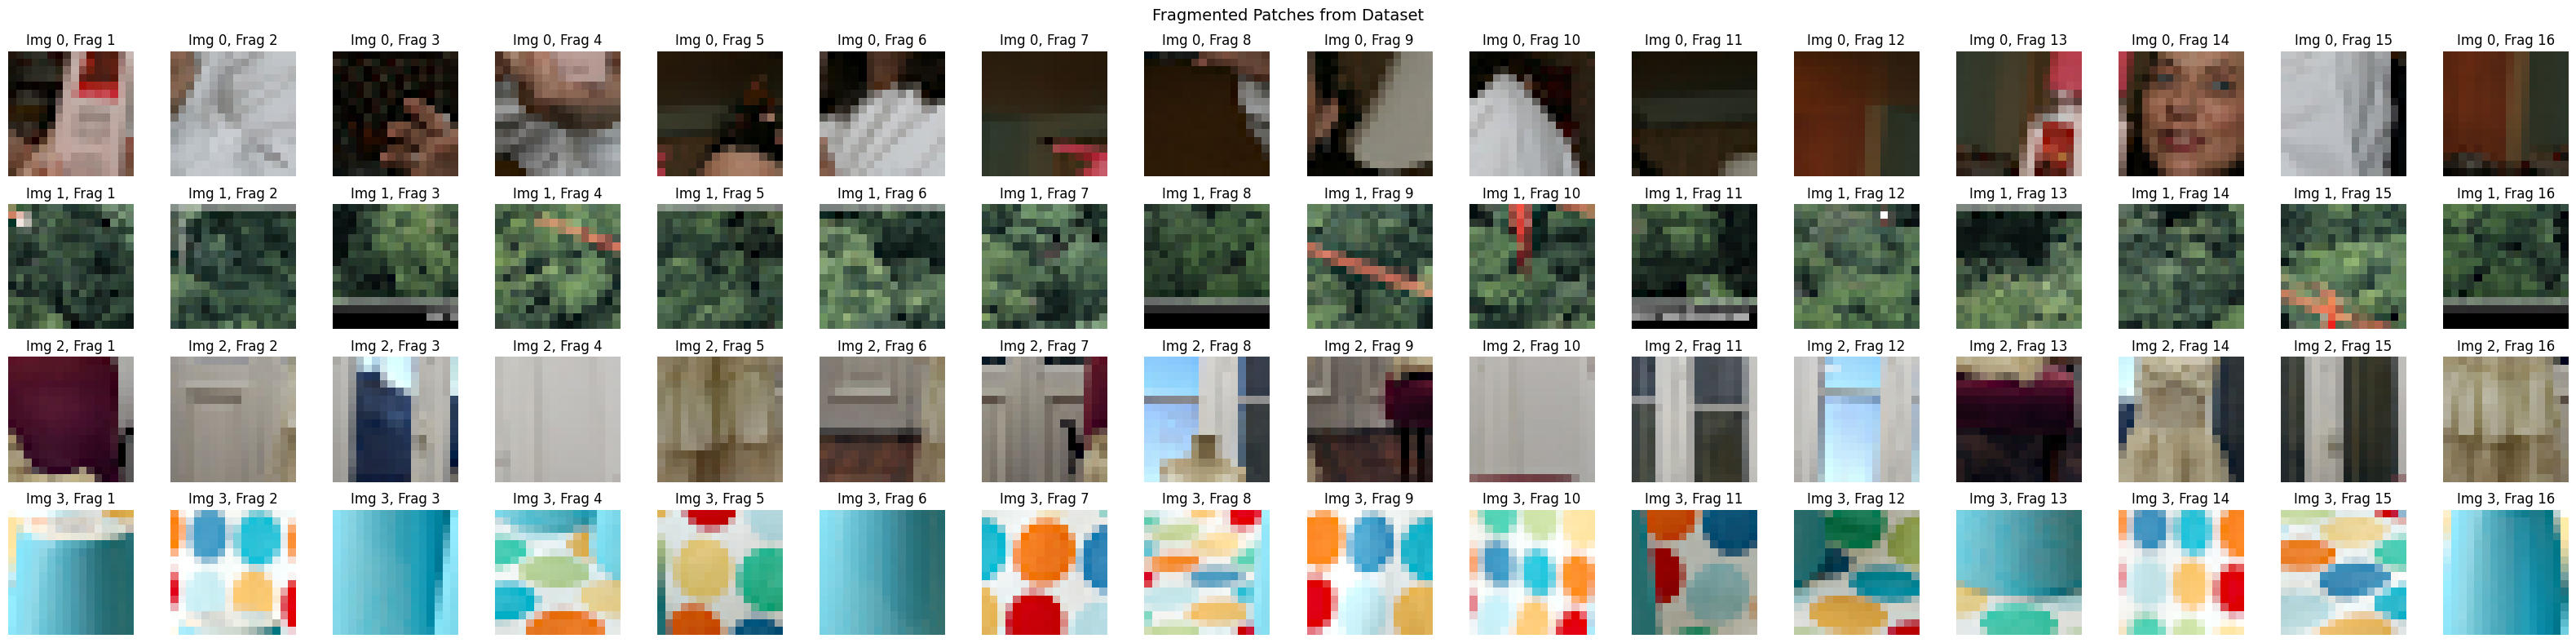

In [124]:
import matplotlib.pyplot as plt

# Visualise a few examples from the dataset
fig, axes = plt.subplots(4, FRAGMENTS_PER_IMAGE, figsize=(FRAGMENTS_PER_IMAGE * 2, 8))

for i in range(4):
    fragments, idx = train_dataset[i]
    for j in range(FRAGMENTS_PER_IMAGE):
        img = fragments[j].permute(1, 2, 0).numpy()  # CHW to HWC
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Img {idx}, Frag {j+1}")

plt.suptitle("Fragmented Patches from Dataset", fontsize=14)
plt.tight_layout()
plt.show()

In [125]:
import torchvision


class SimCLRProjectionHead(nn.Module):
    def __init__(self, input_dim=512, projection_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_dim, projection_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', projection_dim=128):
        super().__init__()
        self.encoder = models.resnet18(weights='IMAGENET1K_V1')
        self.encoder.fc = nn.Identity()
        self.projection_head = SimCLRProjectionHead(input_dim=512, projection_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

class GlobalRelationTransformer(nn.Module):
    def __init__(self, embed_dim=128, patch_c=3, patch_h=4, patch_w=4, num_heads=4, num_layers=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(patch_c, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * patch_h * patch_w, embed_dim)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        # x: [B*N, C, H, W] — fully shuffled
        z = self.encoder(x)  # [B*N, D]
        z = z.unsqueeze(0)   # [1, B*N, D] for Transformer
        z = self.transformer(z)  # [1, B*N, D]
        z = z.squeeze(0)     # [B*N, D]
        return self.projector(z)



class ResNetTransformer(nn.Module):
    def __init__(self, embed_dim=128, transformer_layers=3, num_heads=4):
        super().__init__()

        # ResNet backbone (truncate final layer)
        backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])  # output: [B, 512, H', W']
        self.fc = nn.Linear(512, embed_dim)  # reduce to desired dim

        self.pos_embed = nn.Parameter(torch.randn(1, 1024, embed_dim))  # max 1024 patches
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):

        feat = self.encoder(x)  # [B*N, 512, H', W']
        #print("feat ", feat.shape)
        feat = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)  # [B*N, 512]
        #print("feat ", feat.shape)
        z = self.fc(feat)  # [B*N, embed_dim]
        #print("z ", z.shape)

        # Add position encoding
        z = z.unsqueeze(0)  # [1, B*N, D]
        #z = z + self.pos_embed[:, :z.size(1), :]  # make sure it's added correctly: [1, B*N, D]

        z = self.transformer(z)  # [1, B*N, D]
        z = z.squeeze(0)  # [B*N, D]
        return self.projector(z)  # [B*N, D



In [126]:
dataloader_train = DataLoader(train_dataset, batch_size=10, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [127]:
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.cluster import KMeans

# Now safe to import sklearn/hdbscan/etc
from sklearn.metrics import adjusted_rand_score




In [ ]:
from image_toolkit.nets import GATPatchCluster, create_patch_graph, GATPatchClusterVIT, ViTPatchEmbedder, TransformerPatchCluster
from sklearn.cluster import KMeans
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torch
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATConv




        
# Hyperparameters
EPOCHS = 100
LR = 1e-05
#model = SimCLRModel(projection_dim=256).to(DEVICE)
#model = GATPatchCluster(device=DEVICE,embed_dim=256).to(DEVICE) #0.5

#model = TransformerPatchCluster(embed_dim=256,nhead=8,device=DEVICE,num_layers=10).to(DEVICE) #0.72
#model = GATPatchClusterVIT(device=DEVICE,embed_dim=128,gat_heads=4).to(DEVICE)
#model = ViTPatchEmbedder().to(DEVICE)
#model = GlobalRelationTransformer(embed_dim=EMBED_DIM).to(DEVICE)
#model = ResNetTransformer(transformer_layers=1,num_heads=1,embed_dim=EMBED_DIM).to(DEVICE)
#optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max', factor=0.5, patience=5)
#lr_scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

val_losses = model.train_model(dataloader_train,
                  dataloader_test,
                  optimizer,
                  lr_scheduler,
                  epochs=100,
                  device=DEVICE,
                  temperature=0.33#,top_k=5
                  )



Epoch 1/100: 100%|██████████| 10000/10000 [08:47<00:00, 18.97it/s]


Epoch [1/100], Loss: 3.3919
Epoch [1/100], ARI: 0.7519
Model saved at epoch 1 with ARI: 0.7519
Current learning rate: [1e-05]


Epoch 2/100: 100%|██████████| 10000/10000 [08:46<00:00, 18.98it/s]


Epoch [2/100], Loss: 3.3783
Epoch [2/100], ARI: 0.7605
Model saved at epoch 2 with ARI: 0.7605
Current learning rate: [1e-05]


Epoch 3/100: 100%|██████████| 10000/10000 [08:53<00:00, 18.76it/s]


Epoch [3/100], Loss: 3.3681
Epoch [3/100], ARI: 0.7648
Model saved at epoch 3 with ARI: 0.7648
Current learning rate: [1e-05]


Epoch 4/100: 100%|██████████| 10000/10000 [08:52<00:00, 18.80it/s]


Epoch [4/100], Loss: 3.3617
Epoch [4/100], ARI: 0.7611
Current learning rate: [1e-05]


Epoch 5/100: 100%|██████████| 10000/10000 [08:48<00:00, 18.92it/s]


Epoch [5/100], Loss: 3.3549
Epoch [5/100], ARI: 0.7727
Model saved at epoch 5 with ARI: 0.7727
Current learning rate: [1e-05]


Epoch 6/100: 100%|██████████| 10000/10000 [08:48<00:00, 18.91it/s]


Epoch [6/100], Loss: 3.3517
Epoch [6/100], ARI: 0.7712
Current learning rate: [1e-05]


Epoch 7/100: 100%|██████████| 10000/10000 [08:51<00:00, 18.80it/s]


Epoch [7/100], Loss: 3.3461
Epoch [7/100], ARI: 0.7775
Model saved at epoch 7 with ARI: 0.7775
Current learning rate: [1e-05]


Epoch 8/100:  54%|█████▎    | 5352/10000 [04:42<04:04, 19.04it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch [10/100], ARI: 0.7734
Current learning rate: [1e-05]


Epoch 11/100:  62%|██████▏   | 6196/10000 [05:27<03:20, 19.02it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 14/100: 100%|██████████| 10000/10000 [08:42<00:00, 19.13it/s]


Epoch [14/100], Loss: 3.3236
Epoch [14/100], ARI: 0.7854
Model saved at epoch 14 with ARI: 0.7854
Current learning rate: [1e-05]


Epoch 15/100: 100%|██████████| 10000/10000 [08:32<00:00, 19.51it/s]


Epoch [15/100], Loss: 3.3213
Epoch [15/100], ARI: 0.7924
Model saved at epoch 15 with ARI: 0.7924
Current learning rate: [1e-05]


Epoch 16/100: 100%|██████████| 10000/10000 [08:58<00:00, 18.58it/s]


Epoch [16/100], Loss: 3.3173
Epoch [16/100], ARI: 0.7864
Current learning rate: [1e-05]


Epoch 17/100: 100%|██████████| 10000/10000 [08:51<00:00, 18.82it/s]


Epoch [17/100], Loss: 3.3151
Epoch [17/100], ARI: 0.7849
Current learning rate: [1e-05]


Epoch 18/100: 100%|██████████| 10000/10000 [08:49<00:00, 18.87it/s]


Epoch [18/100], Loss: 3.3118
Epoch [18/100], ARI: 0.7860
Current learning rate: [1e-05]


Epoch 19/100: 100%|██████████| 10000/10000 [08:49<00:00, 18.87it/s]


Epoch [19/100], Loss: 3.3092
Epoch [19/100], ARI: 0.7679
Current learning rate: [1e-05]


Epoch 20/100: 100%|██████████| 10000/10000 [08:45<00:00, 19.02it/s]


Epoch [20/100], Loss: 3.3074
Epoch [20/100], ARI: 0.7779
Current learning rate: [1e-05]


Epoch 21/100: 100%|██████████| 10000/10000 [08:48<00:00, 18.91it/s]


Epoch [21/100], Loss: 3.3051
Epoch [21/100], ARI: 0.7990
Model saved at epoch 21 with ARI: 0.7990
Current learning rate: [1e-05]


Epoch 22/100: 100%|██████████| 10000/10000 [08:53<00:00, 18.73it/s]


Epoch [22/100], Loss: 3.3036
Epoch [22/100], ARI: 0.7947
Current learning rate: [1e-05]


Epoch 23/100: 100%|██████████| 10000/10000 [08:53<00:00, 18.73it/s]


Epoch [23/100], Loss: 3.3014
Epoch [23/100], ARI: 0.7896
Current learning rate: [1e-05]


Epoch 24/100:  13%|█▎        | 1270/10000 [01:07<07:46, 18.70it/s]

🧠 Suggestions to Improve Clustering

1. Improve Training Signal
	•	Use a stronger contrastive loss, like NT-Xent (from SimCLR), with temperature scaling and softmax.
	•	Include hard negatives instead of random ones.
	•	Increase EPOCHS (50+), and possibly reduce learning rate gradually.

2. Embed More Patch Context
	•	Use larger patches or positional encoding to capture more spatial cues.
	•	Consider a Transformer or CNN with global receptive field.

3. More Patches per Image
	•	More fragment pairs during training allow the model to learn more consistent representations per source image.

4. Clustering Setup
	•	Try tuning min_cluster_size in HDBSCAN.
	•	Alternatively, try KMeans (if you roughly know the number of source images).

In [129]:
#from image_toolkit.nets import evaluate_clustering_on_validation
model.load_weights("best_model_epoch_6.pth")
avg_ari = evaluate_clustering_on_validation(dataloader_test, model, device=DEVICE)
print(avg_ari)

Weights loaded from best_model_epoch_6.pth
(np.float64(0.7442341661336566), np.float64(0.843913374976982), np.float32(0.71514815))


In [120]:
# now i want to debug

batch, idx= next(iter(dataloader_train))


images1 = batch[0]
print(images1.shape)
images2 = batch[1]

# now compute the embeddings
model.eval()
with torch.no_grad():

        # Forward pass
    embeddings1 = model(images1.to(DEVICE))
    embeddings2 = model(images2.to(DEVICE))
    # compute cosine similarity of embeddings
    print("embeddings ", embeddings1.shape)
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings1[2].unsqueeze(0))


    print("sim 0 vs 1:", sim.item())
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings2[6].unsqueeze(0))
    print("sim 0 vs 2:", sim.item())




torch.Size([16, 3, 16, 16])
embeddings  torch.Size([16, 256])
sim 0 vs 1: 0.31454935669898987
sim 0 vs 2: 0.10432292520999908


10 16


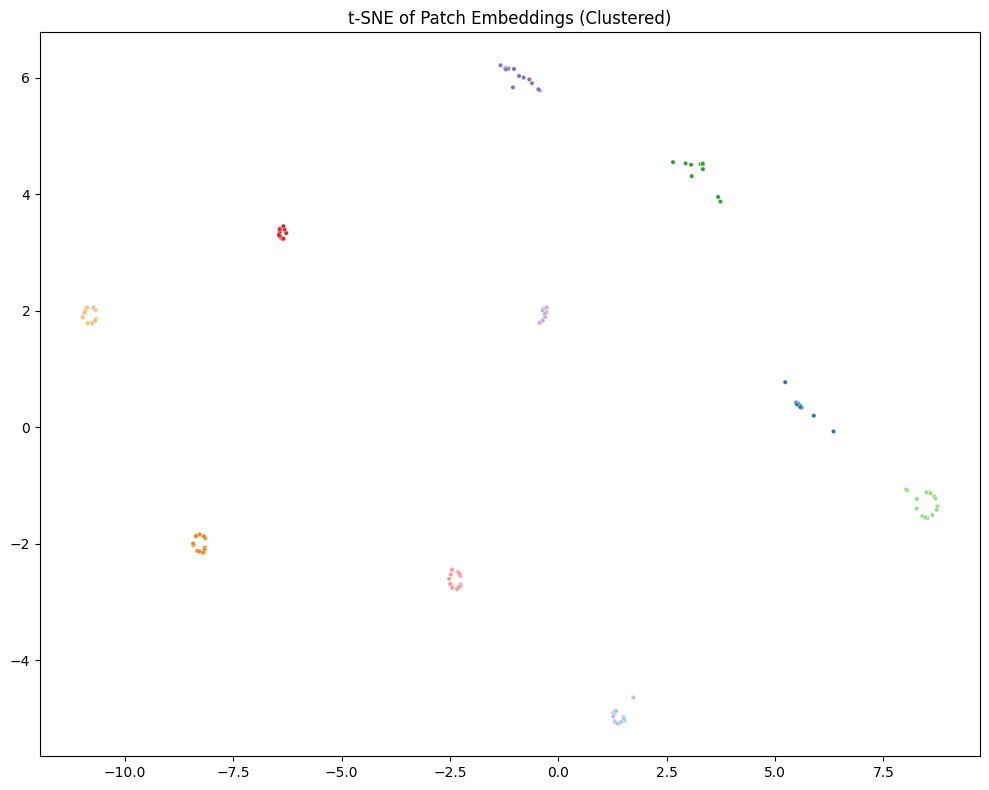

In [121]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering


# Reduce number of samples to avoid OOM
MAX_IMAGES = 4  # use fewer if needed
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for i, (batch, labels) in enumerate(dataloader_train):
        if len(all_labels) >= MAX_IMAGES * batch.size(1):
            break
        B, N, C, H, W = batch.shape
        print(B , N)
        batch = batch.view(B * N, C, H, W).to(DEVICE)
        labels = torch.arange(B).repeat_interleave(N).to(DEVICE)
        
        emb = model(batch).cpu()
        all_embeddings.append(emb)
        all_labels.extend([i] * emb.size(0))

# Combine
embeddings = torch.cat(all_embeddings).numpy()
labels = torch.arange(B).repeat_interleave(N)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(embeddings)

# KMeans (optional)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette="tab20", s=10, legend=False)
plt.title("t-SNE of Patch Embeddings (Clustered)")
plt.tight_layout()
plt.show()

In [117]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score


def cluster_and_score(embeddings: torch.Tensor, true_labels: list[int],B) -> float:
    """
    Perform HDBSCAN clustering and compute clustering accuracy via ARI.

    Args:
        embeddings (torch.Tensor): Tensor of shape [N, D], patch embeddings.
        true_labels (List[int]): Ground-truth image indices for each patch.

    Returns:
        ari (float): Adjusted Rand Index between predicted and true labels.
    """
    embeddings_np = embeddings.detach().cpu().numpy()
    clusterer =  AgglomerativeClustering(n_clusters=B)
    #clusterer = SpectralClustering(n_clusters=B, affinity='nearest_neighbors', assign_labels='kmeans')
    pred_labels = clusterer.fit_predict(embeddings_np)
    true_labels = np.array(true_labels)
    # print("true_labels ", true_labels)
    # print("pred_labels ", pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    silhouette = silhouette_score(embeddings_np, pred_labels)

    return ari,nmi,silhouette


def evaluate_clustering_on_validation( dataloader,model,device):
    """
    Evaluate clustering performance on validation set.
    Args:
        :param dataloader (DataLoader): DataLoader for validation set.
        :param model (nn.Module): Trained model for generating embeddings
        :param device:
    """
    ari_list,nmi_list,sil_list = [],[],[]
    for batch, labels in dataloader:
        batch = batch.to(device)
        with torch.no_grad():

            B, N, C, H, W = batch.shape

            # reshape to [B*N, C, H, W]

            true_labels = labels.numpy().repeat(N)
            #print("true_labels ", true_labels)
            batch = batch.view(B * N, C, H, W)

            # Get embeddings
            embeddings = model(batch)

            #embeddings = embeddings.view(-1, embeddings.shape[-1])
            #print(embeddings.shape)
            # Compute ARI
            ari,nmi,sil = cluster_and_score(embeddings, true_labels,B)
            ari_list.append(ari)
            nmi_list.append(nmi)
            sil_list.append(sil)
            #print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    # Average ARI over all batches
    avg_ari = np.mean(ari_list)
    avg_nmi = np.mean(nmi_list)
    avg_sil = np.mean(sil_list)
    
    return avg_ari, avg_nmi, avg_sil
avg_ari = evaluate_clustering_on_validation(dataloader_test, model, device=DEVICE)
print(avg_ari)


(np.float64(0.7321795536539993), np.float64(0.8378281689344474), np.float32(0.74769187))


In [ ]:
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Training loop


In [ ]:
!pip install torch_geometric

In [31]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [27]:
B

10

In [30]:
torch.arange(B).repeat_interleave(N)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])